# Проект Обучение с учителем

Цель исследования - разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

Ссылка на Github https://github.com/DaryaNekrasova/YandexPracticum

# Описание исходных данных

**market_file** - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_time.csv** - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

**market_money.csv** - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. 
- Выручка — сумма выручки за период.

**money.csv** - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Загрузка данных

Импортируем необходимые библиотеки

In [1]:
!pip install -q phik

In [2]:
!pip install -q shap

In [3]:
!pip install -U -q scikit-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    recall_score,
    precision_score,
    confusion_matrix,
    accuracy_score
)
import scipy.stats as st 
from numpy import linspace
import numpy as np
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score

# импортируем модель
from sklearn.tree import DecisionTreeClassifier

# загрузите нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.sv import SVC
from sklearn.model_selection import RandomizedSearchCV

import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

from sklearn.cluster import KMeans

Загрузим исходные данные из csv-файлов **/datasets/market_file.csv**, **/datasets/market_money.csv**, **/datasets/market_time.csv** и **/datasets/money.csv**.

In [5]:
m_file = pd.read_csv('/datasets/market_file.csv')
m_money = pd.read_csv('/datasets/market_money.csv')
time = pd.read_csv('/datasets/market_time.csv')
money_pr = pd.read_csv('/datasets/money.csv', delimiter=';', decimal = ',')

Выведем первые строки полченных датафреймов.

In [6]:
m_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
m_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
money_pr.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Просмотрим общую информацию о поведении покупателей.

In [10]:
m_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В датафрейме 1300 строк, пропущенные значения отсутствуют во всех столбцах. Типы данных корректны.
Рассмотрим информацию о выручке магазина.

In [11]:
m_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В таблице нет пропусков. Общее количество строк 3900. Типы данных корректны.
Выведем общую информацию о времени, которое провел покупатель на сайте магазина.

In [12]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Всего 2600 записей, пропущенные значения отсутствуют. Типы данных корректны.
Рассмотрим информацию о датафрейме, содержащим информацию о среднемесячной прибыли покупателя за последние 3 месяца.

In [13]:
money_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Среди 1300 строк нет пропущенных значений, но поле Прибыль имеет некорректный тип данных - object вместо числового.

# Шаг 1. Вывод

Загрузили данные из исходных таблиц **/datasets/market_file.csv**, **/datasets/market_money.csv**, **/datasets/market_time.csv** и **/datasets/money.csv**.

В исходных данных нет пропущеных значений. 
Также необходимо проверить на наличие явных и неявных дубликатов.

## Предобработка данных

Исправим названия полей

In [14]:
m_file.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in m_file.columns]
m_money.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in m_money.columns]
time.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in time.columns]
money_pr.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in money_pr.columns]

In [15]:
m_file.columns, m_money.columns, time.columns, money_pr.columns

(Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
        'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
        'акционные_покупки', 'популярная_категория',
        'средний_просмотр_категорий_за_визит',
        'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
        'страниц_за_визит'],
       dtype='object'),
 Index(['id', 'период', 'выручка'], dtype='object'),
 Index(['id', 'период', 'минут'], dtype='object'),
 Index(['id', 'прибыль'], dtype='object'))

Проверим таблицы на наличие явных дубликатов.

In [16]:
print('Количество явных дубликатов', m_file.duplicated().sum())
print('Количество явных дубликатов', m_money.duplicated().sum())
print('Количество явных дубликатов', time.duplicated().sum())
print('Количество явных дубликатов', money_pr.duplicated().sum())

Количество явных дубликатов 0
Количество явных дубликатов 0
Количество явных дубликатов 0
Количество явных дубликатов 0


Явных дубликатов в исходных данных нет. Проверим категориальные поля на наличие неявных дубликатов.

In [17]:
m_file['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

In [18]:
m_file['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

In [19]:
m_file['разрешить_сообщать'].value_counts()

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

In [20]:
m_file['популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

In [21]:
m_money['период'].value_counts()

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64

In [22]:
time['период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

**Тип сервиса** - содержит опечатку при значении стандарт. <br>
В периоде таблицы **time** опечатка в названия месяца. <br>
Исправим недочеты в исходных данных. <br>

In [23]:
m_file.loc[m_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
m_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

In [24]:
time.loc[time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
time['период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

# Шаг 2. Вывод 

Были исправлены недочеты в типах исходных данных - прибыль из таблицы **money** переведена в формат float. 
На предыдущем шаге при вызове функции .info() отсутствующие значения не были обнаружены ни в одном столбце исходных данных.
Во всех исходных данных явных дубликатов нет, но были неявные в поле Тип сервиса.
Исправлены опечатка в наименовании периода из таблицы **time**.

##  Исследовательский анализ данных

Проведем исследовательский анализ данных для таблицы **m_file** <br>
Рассмотрим соотношение пользователей по покупательской активности

In [25]:
m_file['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

Более половины пользователей сохранили покупательскую активность. Доля покупателей, у которых она снизилась составляет 38% <br>
Рассмотрим распределение покупателей по уровню сервиса

In [26]:
m_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

In [27]:
m_file.groupby(['тип_сервиса', 'покупательская_активность'])['id'].count()

тип_сервиса  покупательская_активность
премиум      Прежний уровень              206
             Снизилась                    170
стандарт     Прежний уровень              596
             Снизилась                    328
Name: id, dtype: int64

In [28]:
m_file.groupby(['тип_сервиса', 'покупательская_активность'])['id'].count()/m_file.groupby(['тип_сервиса'])['id'].count()

тип_сервиса  покупательская_активность
премиум      Прежний уровень              0.547872
             Снизилась                    0.452128
стандарт     Прежний уровень              0.645022
             Снизилась                    0.354978
Name: id, dtype: float64

Основная доля покупателей - с сервисом Стандарт - 71%. <br> У покупателей с уровнем сервиса "премиум" покупательская активность снизилась почти на 10% больше, чем у покупателей с сервисом стандарт.

In [29]:
m_file['разрешить_сообщать'].value_counts()

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

Большая часть покупателей согласны получать предложения о товаре.

In [30]:
m_file.groupby(['тип_сервиса', 'разрешить_сообщать'])['id'].count()/m_file.groupby(['тип_сервиса'])['id'].count()

тип_сервиса  разрешить_сообщать
премиум      да                    0.869681
             нет                   0.130319
стандарт     да                    0.687229
             нет                   0.312771
Name: id, dtype: float64

Дополнительные предложения о товаре интересно получать 86,9% покупателей с подпиской Премиум. Доля интересующемся такими предложениями в сегменте Стандарт заметно ниже - 68,7%

Далее рассмотрим количественные показатели. <br> **Маркет_актив_6_мес** - cреднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

In [31]:
m_file['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

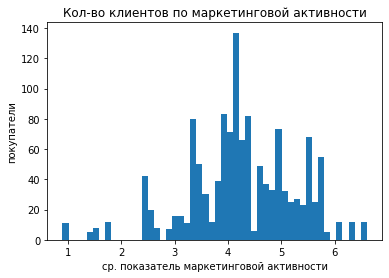

In [32]:
m_file['маркет_актив_6_мес'].plot(kind = 'hist', bins = 50)
plt.title('Кол-во клиентов по маркетинговой активности')
plt.xlabel('ср. показатель маркетинговой активности')
plt.ylabel('покупатели')
plt.show()

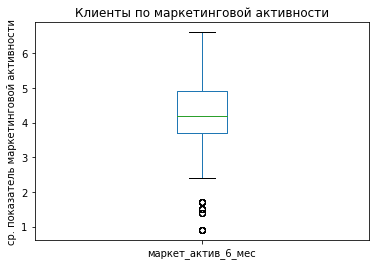

In [33]:
m_file['маркет_актив_6_мес'].plot(kind = 'box')
plt.title('Клиенты по маркетинговой активности')
plt.ylabel('ср. показатель маркетинговой активности')
plt.show()

Медианное значение маркетинговой активности составляет 4.2. На диаграмме ящик с усами есть несколько значений от 1 до 2 - оставим их в исходных данных - такие значения не являются аномальными для данного показателя.

Клиентов по маркетинговой активности можно разбить на группы
- с очень низкой активностью (до 2) и средней (более двух)
- низкой - до 3
- средняя  до 6
- высокая - более 6

In [34]:
m_file.loc[m_file['маркет_актив_6_мес'] < 2, 'марк_категория_6_мес'] = 'очень низкая'
m_file.loc[(m_file['маркет_актив_6_мес'] >= 2) & (m_file['маркет_актив_6_мес'] < 3), 'марк_категория_6_мес'] = 'низкая'
m_file.loc[(m_file['маркет_актив_6_мес'] >= 3) & (m_file['маркет_актив_6_мес'] < 6), 'марк_категория_6_мес'] = 'средняя'
m_file.loc[(m_file['маркет_актив_6_мес'] > 6), 'марк_категория_6_мес'] = 'высокая'

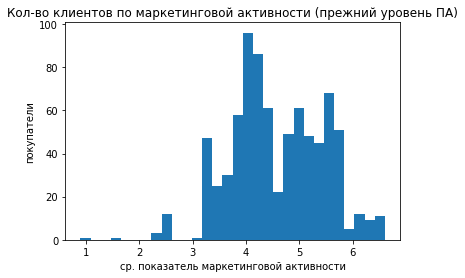

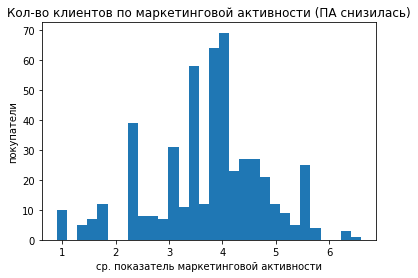

In [35]:
m_file.loc[m_file['покупательская_активность'] == 'Прежний уровень','маркет_актив_6_мес'].plot(kind = 'hist', bins = 30)
plt.title('Кол-во клиентов по маркетинговой активности (прежний уровень ПА)')
plt.xlabel('ср. показатель маркетинговой активности')
plt.ylabel('покупатели')
plt.show()

m_file.loc[m_file['покупательская_активность'] == 'Снизилась','маркет_актив_6_мес'].plot(kind = 'hist', bins = 30)
plt.title('Кол-во клиентов по маркетинговой активности (ПА снизилась)')
plt.xlabel('ср. показатель маркетинговой активности')
plt.ylabel('покупатели')
plt.show()

В среднем количество маркетинговых коммуникаций составляет 4.2%. Гистограмма распределения клиентов с покупательской активности, оставшейся на прежнем уровне, смещен вправо относительно гистограммы с покупателями, у которых этот показатель снизился. Очевидно, что реклама, звонки и рассылки положительно влияют на продажи. <br>
Рассмотрим данный показатель за последний месяц

In [36]:
m_file['маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

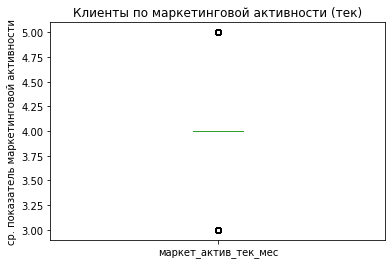

In [37]:
m_file['маркет_актив_тек_мес'].plot(kind = 'box')
plt.title('Клиенты по маркетинговой активности (тек)')
plt.ylabel('ср. показатель маркетинговой активности')
plt.show()

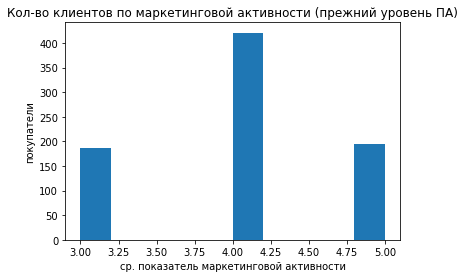

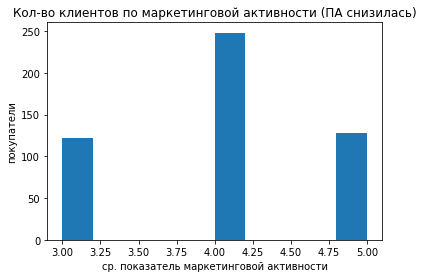

In [38]:
m_file.loc[m_file['покупательская_активность'] == 'Прежний уровень','маркет_актив_тек_мес'].plot(kind = 'hist')
plt.title('Кол-во клиентов по маркетинговой активности (прежний уровень ПА)')
plt.xlabel('ср. показатель маркетинговой активности')
plt.ylabel('покупатели')
plt.show()

m_file.loc[m_file['покупательская_активность'] == 'Снизилась','маркет_актив_тек_мес'].plot(kind = 'hist')
plt.title('Кол-во клиентов по маркетинговой активности (ПА снизилась)')
plt.xlabel('ср. показатель маркетинговой активности')
plt.ylabel('покупатели')
plt.show()

За последний месяц маркетинговая активность снизилась по отношению к среднему показателю за 6 месяцев (с 4.2 до 4). При этом за последний месяц маркетинговая активность не повлияла на покупательскую способность. Медианное значение для выборки составляет 4.<br>
Расмотрим распределение покупателей по длительности пользования сервисом

Маркетинговую активность за последний месяц можно разделить на три группы

In [39]:
m_file.loc[(m_file['маркет_актив_тек_мес'] < 4), 'марк_категория_мес'] = 'низкая'
m_file.loc[(m_file['маркет_актив_тек_мес'] >= 4) & (m_file['маркет_актив_6_мес'] < 4.75), 'марк_категория_мес'] = 'средняя'
m_file.loc[(m_file['маркет_актив_тек_мес'] >= 4.75), 'марк_категория_мес'] = 'высокая'

In [40]:
m_file['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

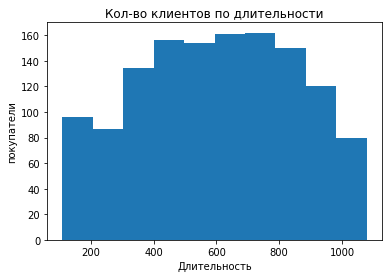

In [41]:
m_file['длительность'].plot(kind = 'hist')
plt.title('Кол-во клиентов по длительности')
plt.xlabel('Длительность')
plt.ylabel('покупатели')
plt.show()

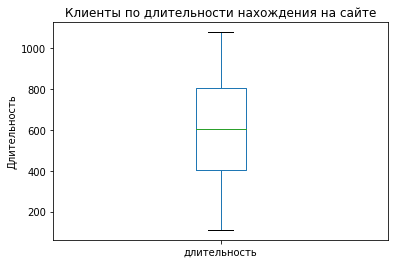

In [42]:
m_file['длительность'].plot(kind = 'box')
plt.title('Клиенты по длительности нахождения на сайте')
plt.ylabel('Длительность')
plt.show()

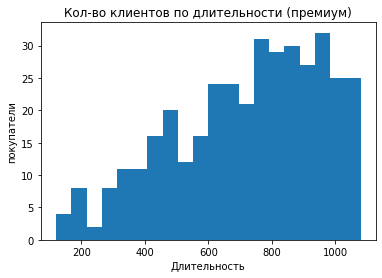

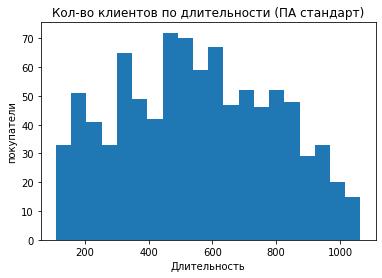

In [43]:
m_file.loc[m_file['тип_сервиса'] == 'премиум','длительность'].plot(kind = 'hist', bins = 20)
plt.title('Кол-во клиентов по длительности (премиум)')
plt.xlabel('Длительность')
plt.ylabel('покупатели')
plt.show()

m_file.loc[m_file['тип_сервиса'] == 'стандарт','длительность'].plot(kind = 'hist', bins = 20)
plt.title('Кол-во клиентов по длительности (ПА стандарт)')
plt.xlabel('Длительность')
plt.ylabel('покупатели')
plt.show()

Большая часть покупателей зарегистрирована на сервисе от 400 до 800 дней. Покупатели из Премиум сегмента - более старые пользователи по сравнению с покупателями со стандартной подпиской - возможно Премиум предоставляют пользователям по истечению некоторого срока после регистрации на сайте - с ростом длительности растет также и количество клиентов в сегменте премиум. Среди новых покупателей (длительность менее 400) - очень мало покупателей с сегментом Премиум

Рассмотрим более подробно распределение покупателей по доле акционным покупок

In [44]:
m_file['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

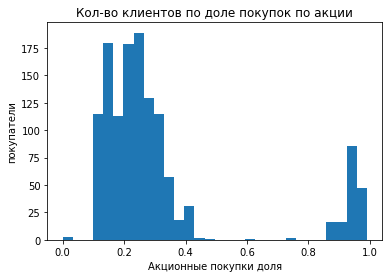

In [45]:
m_file['акционные_покупки'].plot(kind = 'hist', bins = 30)
plt.title('Кол-во клиентов по доле покупок по акции')
plt.xlabel('Акционные покупки доля')
plt.ylabel('покупатели')
plt.show()

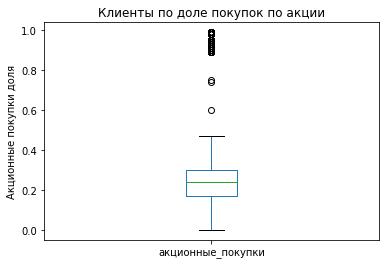

In [46]:
m_file['акционные_покупки'].plot(kind = 'box')
plt.title('Клиенты по доле покупок по акции')
plt.ylabel('Акционные покупки доля')
plt.show()

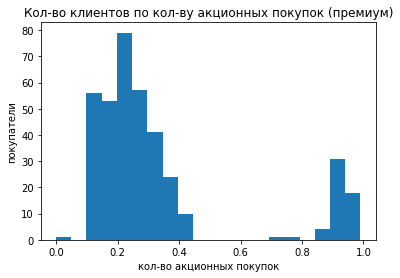

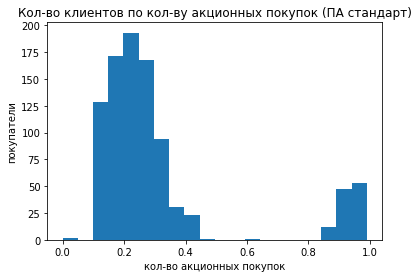

In [47]:
m_file.loc[m_file['тип_сервиса'] == 'премиум','акционные_покупки'].plot(kind = 'hist', bins = 20)
plt.title('Кол-во клиентов по кол-ву акционных покупок (премиум)')
plt.xlabel('кол-во акционных покупок')
plt.ylabel('покупатели')
plt.show()

m_file.loc[m_file['тип_сервиса'] == 'стандарт','акционные_покупки'].plot(kind = 'hist', bins = 20)
plt.title('Кол-во клиентов по кол-ву акционных покупок (ПА стандарт)')
plt.xlabel('кол-во акционных покупок')
plt.ylabel('покупатели')
plt.show()

In [48]:
m_file.loc[m_file['тип_сервиса'] == 'премиум','акционные_покупки'].describe()

count    376.000000
mean       0.335851
std        0.260106
min        0.000000
25%        0.170000
50%        0.240000
75%        0.320000
max        0.990000
Name: акционные_покупки, dtype: float64

In [49]:
m_file.loc[m_file['тип_сервиса'] == 'стандарт','акционные_покупки'].describe()

count    924.000000
mean       0.313279
std        0.245388
min        0.000000
25%        0.170000
50%        0.240000
75%        0.300000
max        0.990000
Name: акционные_покупки, dtype: float64

В среднем доля покупок по акции составляет 24%. Для клиентов Премиум и Стандарт - показатели практически равны.

Клиентов по признаку акционных покупок разделим на две категории

In [50]:
m_file.loc[(m_file['акционные_покупки'] < 0.6), 'акции_категория'] = 'ниже среднего'
m_file.loc[(m_file['акционные_покупки'] >= 0.6), 'акции_категория'] = 'выше среднего'

Рассмотрим популярные категории у клиентов

In [51]:
m_file['популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

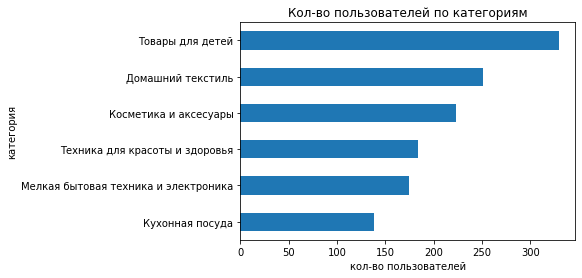

In [52]:
m_file['популярная_категория'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Кол-во пользователей по категориям')
plt.xlabel('кол-во пользователей')
plt.ylabel('категория')
plt.show()

Самая популярная категория покупателей - товары для детей <br>
Рассмотрим количество неоплаченных товаров в корзине

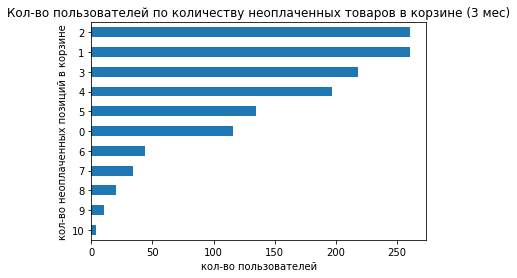

In [53]:
m_file['неоплаченные_продукты_штук_квартал'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Кол-во пользователей по количеству неоплаченных товаров в корзине (3 мес)')
plt.xlabel('кол-во пользователей')
plt.ylabel('кол-во неоплаченных позиций в корзине')
plt.show()

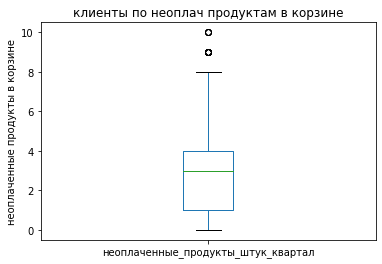

In [54]:
m_file['неоплаченные_продукты_штук_квартал'].plot(kind = 'box')
plt.title('клиенты по неоплач продуктам в корзине')
plt.ylabel('неоплаченные продукты в корзине')
plt.show()

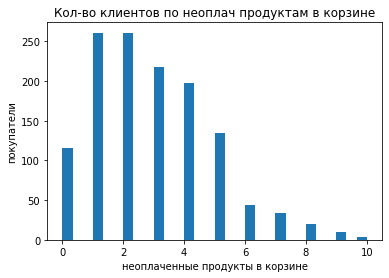

In [55]:
m_file['неоплаченные_продукты_штук_квартал'].plot(kind = 'hist', bins = 30)
plt.title('Кол-во клиентов по неоплач продуктам в корзине')
plt.xlabel('неоплаченные продукты в корзине')
plt.ylabel('покупатели')
plt.show()

У 75% пользователей до 4 неоплаченных позиций в корзине. В среднем этот показатель составляет 3 товара.

Рассмотрим количество сбоев, которые коснулись покупателя во время посещения сайта.

In [56]:
m_file['ошибка_сервиса'].value_counts()

4    257
3    226
5    208
2    189
6    156
7     92
1     74
8     66
0     17
9     15
Name: ошибка_сервиса, dtype: int64

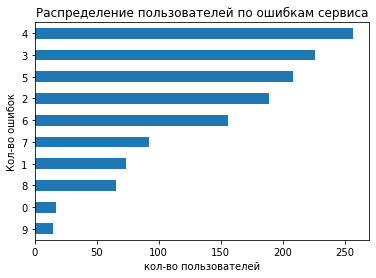

In [57]:
m_file['ошибка_сервиса'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Распределение пользователей по ошибкам сервиса')
plt.xlabel('кол-во пользователей')
plt.ylabel('Кол-во ошибок')
plt.show()

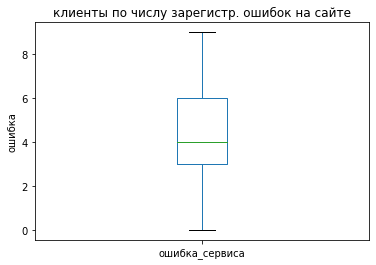

In [58]:
m_file['ошибка_сервиса'].plot(kind = 'box')
plt.title('клиенты по числу зарегистр. ошибок на сайте')
plt.ylabel('ошибка')
plt.show()

In [59]:
m_file['ошибка_сервиса'].value_counts() / m_file['ошибка_сервиса'].count()

4    0.197692
3    0.173846
5    0.160000
2    0.145385
6    0.120000
7    0.070769
1    0.056923
8    0.050769
0    0.013077
9    0.011538
Name: ошибка_сервиса, dtype: float64

Практически все пользователи сталкивались с ошибкой сервиса. 

Рассмотрим среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [60]:
m_file['страниц_за_визит'].value_counts()

6     127
5     115
4     112
8     109
9     108
10    104
7     102
11     92
3      76
12     73
13     61
2      58
14     53
15     36
16     21
1      20
17     19
18      7
19      5
20      2
Name: страниц_за_визит, dtype: int64

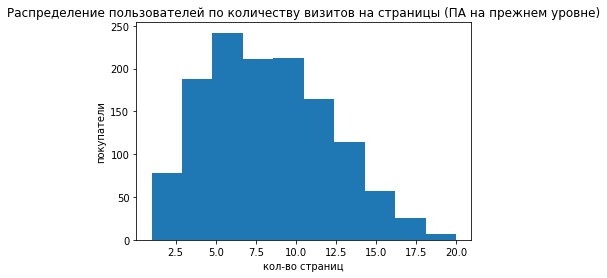

In [61]:
m_file['страниц_за_визит'].plot(kind = 'hist')
plt.title('Распределение пользователей по количеству визитов на страницы (ПА на прежнем уровне)')
plt.xlabel('кол-во страниц')
plt.ylabel('покупатели')
plt.show()

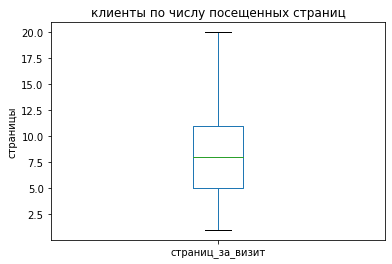

In [62]:
m_file['страниц_за_визит'].plot(kind = 'box')
plt.title('клиенты по числу посещенных страниц')
plt.ylabel('страницы')
plt.show()

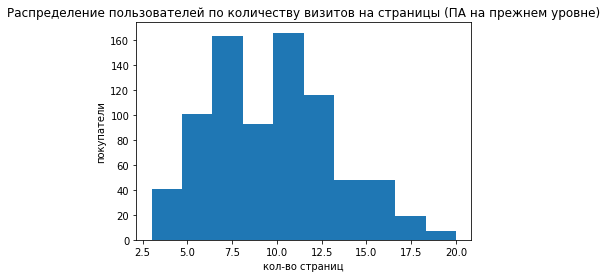

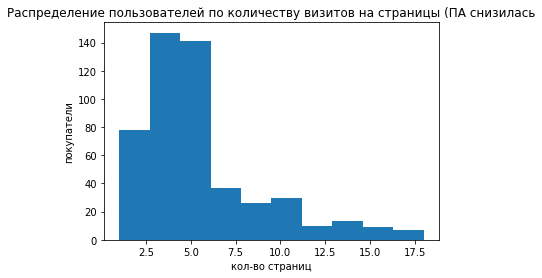

In [63]:
m_file.loc[m_file['покупательская_активность'] == 'Прежний уровень', 'страниц_за_визит'].plot(kind = 'hist')
plt.title('Распределение пользователей по количеству визитов на страницы (ПА на прежнем уровне)')
plt.xlabel('кол-во страниц')
plt.ylabel('покупатели')
plt.show()

m_file.loc[m_file['покупательская_активность'] == 'Снизилась', 'страниц_за_визит'].plot(kind = 'hist')
plt.title('Распределение пользователей по количеству визитов на страницы (ПА снизилась')
plt.xlabel('кол-во страниц')
plt.ylabel('покупатели')
plt.show()

Пользователи посещали различных от 1 до 20 страниц. У пользователей, у которых ппокупательская способность снизилась - этот показатель составляет 1-18 страниц, у покупателей с активностью на прежнем уровне - количество посещенных страниц от 3 до 20, к тому же график распредления у пользователей со сниженной ПА - смещен влево, что говорит о более низком медианном значении посещения страниц

Рассмотрим среднее время (мин), которое покупатель провел на сайте

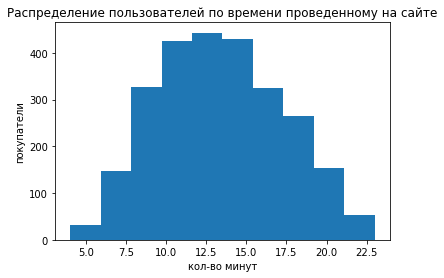

In [64]:
time['минут'].plot(kind = 'hist')
plt.title('Распределение пользователей по времени проведенному на сайте')
plt.xlabel('кол-во минут')
plt.ylabel('покупатели')
plt.show()

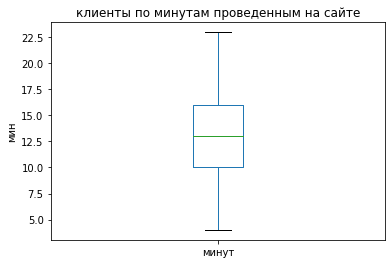

In [65]:
time['минут'].plot(kind = 'box')
plt.title('клиенты по минутам проведенным на сайте')
plt.ylabel('мин')
plt.show()

In [66]:
time.groupby('период')['минут'].median()

период
предыдущий_месяц    13
текущий_месяц       13
Name: минут, dtype: int64

In [67]:
time.groupby('период')['минут'].mean()

период
предыдущий_месяц    13.467692
текущий_месяц       13.204615
Name: минут, dtype: float64

Среднее проведенное время на сайте в текущем и предыдущем месяце не изменилось - составляет 13 минут

Рассмотрим распределение выручки по пользователям и по периодам.

In [68]:
m_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

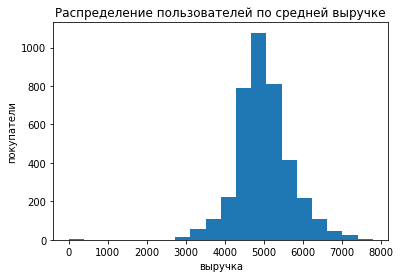

In [69]:
m_money.loc[m_money['выручка'] != 106862.2, 'выручка'].plot(kind = 'hist', bins = 20)
plt.title('Распределение пользователей по средней выручке')
plt.xlabel('выручка')
plt.ylabel('покупатели')
plt.show()

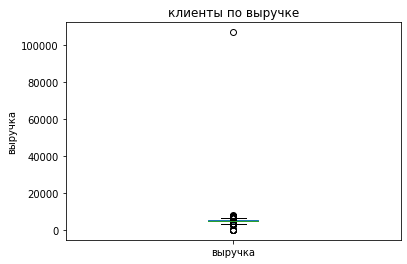

In [70]:
m_money['выручка'].plot(kind = 'box')
plt.title('клиенты по выручке')
plt.ylabel('выручка')
plt.show()

В данной выборке есть один очевидный выброс - 106862.2, удалим данную запись из датафрейма

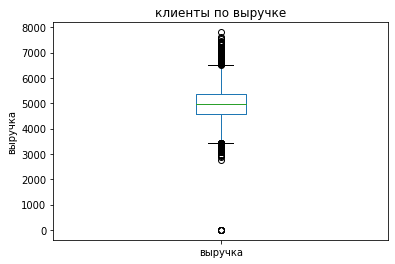

In [71]:
m_money = m_money[m_money['выручка'] != 106862.2]
m_money['выручка'].plot(kind = 'box')
plt.title('клиенты по выручке')
plt.ylabel('выручка')
plt.show()

In [72]:
m_money.groupby('период')['выручка'].median()

период
предыдущий_месяц       5005.0
препредыдущий_месяц    4809.0
текущий_месяц          5179.6
Name: выручка, dtype: float64

В таблице с выручкой по пользователям есть пользователи, которые ничего не покупали. Максимальное значение выручки - 106862 - аномально высокое по сравнение со средним (проверим далее - выброс или нет). Если рассматривать динамику выручки, то за последние три месяца выручка растет

Рассмотрим прибыль по покупателям

In [73]:
money_pr['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

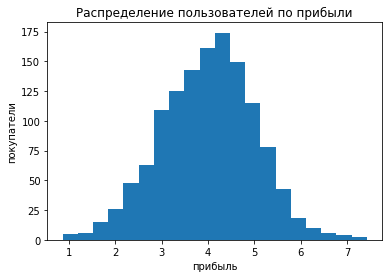

In [74]:
money_pr['прибыль'].plot(kind = 'hist', bins = 20)
plt.title('Распределение пользователей по прибыли')
plt.xlabel('прибыль')
plt.ylabel('покупатели')
plt.show()

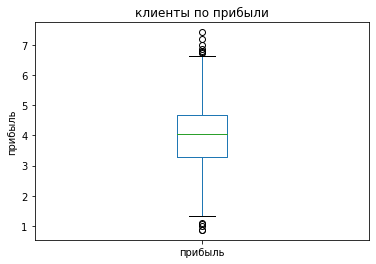

In [75]:
money_pr['прибыль'].plot(kind = 'box')
plt.title('клиенты по прибыли')
plt.ylabel('прибыль')
plt.show()

Среднее значение прибыли с одного покупателя составляет 4 тыс. руб

Отберем клиентов с покупательской активностью не менее трёх месяцев. 

# Шаг 3. Вывод 

- Лишь у 38% покупателей снизилась покупательская способность
- Большая часть клиентов компании - покупатели с подпиской Стандарт (она составляет более 71%)
- Покупательская активность больше снизилась у покупателей с сервисом премиум, чем у покупателей со стандартным сервисом (45% и 35% соответственно)
- Покупатели с сервисом Премиум охотнее соглашаются на получение дополнительных предложений о товаре (86.9%). У покупателей с сервисом стандарт этот показатель заметно ниже - 68.7%
- У покупателей с более низким показателем покупательской активности ниже среднее значение маркетинговой активности за последние полгода. Различная реклама, рассылки, предложения, звонки положительно влияют на уровень продаж и как следствие - на активность покупателей. При этом на покупательскую активность не отразилось значение маркетинговых мероприятий за последний месяц, что может говорить о возможной неэффективности маркетинговых инициатив.
- В среднем покупатели зарегистрированы на сервисе около 600 дней. Основная часть пользователей зарегистрирована от 400 до 800 дней. Среди покупателей с подпиской Премиум - много "старожилов", при этом среди новых покупателей доля таких заметно ниже. 
- Средняя доля покупок по акции составляет 24%. Категория клиента (премиум и стандарт) никак не влияет на данный показатель
- Топ-3 самых популярный категорий покупателей - товары для детей, домашний текстиль и косметика и аксесуары
- У преобладающего числа пользователей есть неоплаченные позиции в корзине - в среднем это значение составляет 3 товара.
- Более 99% покупателей сталкивались с ошибкой сервиса, что говорит о наличии в системе массового сбоя
- Пользователи посещают от 1 до 20 страниц за 1 визит на сайте, при этом показатель у пользователей с ПА на прежнем уровне выше, чем у пользователей со сниженной покупательской активностью. При этом среднее время проведенное на сайте за последние два месяца не изменилось - составляет 13 минут
- В среднем выручка по покупателям составляет 5000 руб при довольно невысокой прибыли - 4 рубля. За последние три месяца средняя выручка за месяц увеличивается
- Было удалено аномальное значение в выручке

## Объединение таблиц

Объединим данные из таблиц **m_file**, **time**, **m_money**

Так как данные о выручке и времени на сайте находятся в одном столбце для всех периодов - немного преобразуем исходные таблицы перед объединением

In [76]:
time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [77]:
time['минут_тек'] = time.loc[time['период'] == 'текущий_месяц', 'минут']
time['минут_пред'] = time.loc[time['период'] == 'предыдущий_месяц', 'минут']
time_join = time.groupby('id').agg({'минут_тек' : 'sum', 'минут_пред': 'sum'})
time_join

,минут_тек,минут_пред
id,,
215348,14.0,13.0
215349,10.0,12.0
215350,13.0,8.0
215351,13.0,11.0
215352,11.0,8.0
...,...,...
216643,7.0,14.0
216644,11.0,12.0
216645,18.0,12.0


In [78]:
m_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [79]:
m_money['выручка_препред'] = m_money.loc[m_money['период'] == 'препредыдущий_месяц', 'выручка']
m_money['выручка_тек'] = m_money.loc[m_money['период'] == 'текущий_месяц', 'выручка']
m_money['выручка_пред'] = m_money.loc[m_money['период'] == 'предыдущий_месяц', 'выручка']
money_join = m_money.groupby('id').agg({'выручка_препред' : 'sum', 'выручка_пред': 'sum', 'выручка_тек': 'sum'})
money_join

,выручка_препред,выручка_пред,выручка_тек
id,,,
215348,0.0,0.0,3293.1
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5
...,...,...,...
216643,4704.0,3664.0,4741.7
216644,5299.0,4729.0,5353.0
216645,5334.0,5160.0,5139.2


Теперь объединим таблицы в одну

In [80]:
total_data = m_file.merge(time_join, on = 'id', how = 'left').merge(money_join, on = 'id', how = 'left')

Отберем клиентов с покупательской активностью не менее 3 месяцев - для более корректного построения модели. Если у клиента не было активности в течение трех последних месяцев - то модель получит нулевые факторы на входе и будет выдавать некорректный результат

In [81]:
total_data = total_data[(total_data['выручка_препред']!=0) & (total_data['выручка_пред']!=0) & (total_data['выручка_тек']!=0)]
total_data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,марк_категория_6_мес,марк_категория_мес,акции_категория,минут_тек,минут_пред,выручка_препред,выручка_пред,выручка_тек
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,средняя,средняя,выше среднего,10.0,12.0,4472.0,5216.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,средняя,низкая,ниже среднего,13.0,8.0,4826.0,5457.5,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,средняя,высокая,выше среднего,13.0,11.0,4793.0,6158.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,средняя,низкая,выше среднего,11.0,8.0,4594.0,5807.5,5872.5
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,средняя,средняя,ниже среднего,10.0,10.0,5124.0,4738.5,5388.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,...,3,11,высокая,низкая,ниже среднего,7.0,14.0,4704.0,3664.0,4741.7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,...,3,9,средняя,NaN,ниже среднего,11.0,12.0,5299.0,4729.0,5353.0
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,...,5,7,средняя,низкая,ниже среднего,18.0,12.0,5334.0,5160.0,5139.2
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,...,5,7,высокая,высокая,ниже среднего,7.0,18.0,4725.0,4923.0,5224.6


# Шаг 4. Вывод 

На данном шаге для более удобного анализа объединила данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, выручке и времени (в минутах), которое покупатель провёл на сайте в течение периода в одну таблицу

Для анализа была взята выборка только с теми клиентам, у которых была активность последние три месяца (выручка больше нуля)

## Корреляционный анализ

Рассчитаем коэфициенты корреляции для всех признаков.

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минут_тек', 'минут_пред', 'выручка_препред', 'выручка_пред', 'выручка_тек']


<AxesSubplot:>

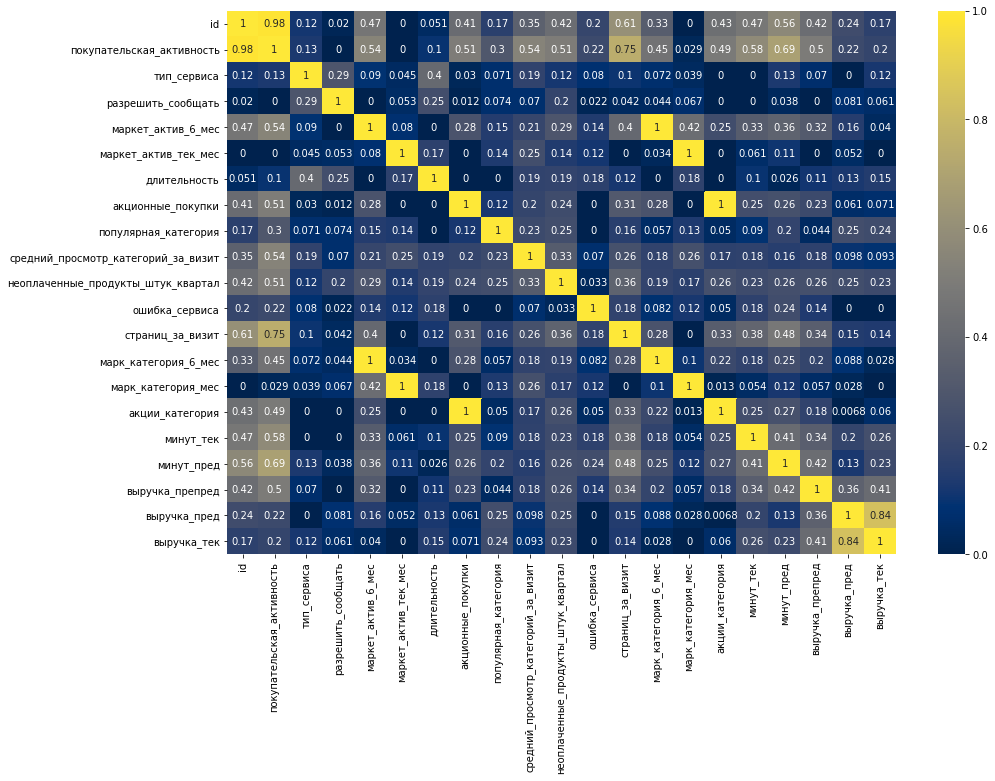

In [82]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(total_data.phik_matrix(),  annot=True, cmap='cividis') 

Мультиколлинеарность отсутствует - между факторами нет коэффициентов корреляции более 0.9.
Также не будем брать в расчет модели фактор id - это просто идентификатор

Согласно матрице на покупательскую активность влияют:


- Маркет_актив_6_мес
- Марк_категория_6_мес
- Акционные_покупки
- Акции_категория
- Популярная категория
- Средний_просмотр_категорий_за_визит'
- Неоплаченные_продукты_штук_квартал
- Страниц_за_визит
- минут_тек
- минут_пред
- выручка_препред


# Шаг 5. Вывод 

На данном этапе провели корреляционный анализ между целевым признаком - покупательская активность и другими параметрами. Основными факторами, влияющими на покупательскую активность являются:
- маркетинговая активность за последние 6 месяцев
- количество акционных покупок
- популярная категория
- количество просмотров категорий за визит
- количество неоплаченных продуктов
- количество просмотренных страниц за визит
- количество минут проведенных на сайте в предыдущий и текущий период
- выручка в препредыдущем периоде
- а также категории клиентов, которые мы выделили ранее по количеству акционных покупок и маркетинговой активности

## Пайплайны

Ранее мы проводили корреляционный анализ - выделим основные влияющие факторы на покупательскую активность
Подготовим пайплайны


Для начала разобьем выборки на тестовую и обучающую

In [83]:
total_data.loc[total_data['покупательская_активность'] == 'Снизилась', 'ПА'] = 1
total_data.loc[total_data['покупательская_активность'] == 'Прежний уровень', 'ПА'] = 0

In [84]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

cols = ['популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
       'маркет_актив_6_мес', 'акционные_покупки', 'страниц_за_визит', 'минут_тек', 'минут_пред', 'выручка_препред',
       'марк_категория_6_мес', 'акции_категория']
X_train, X_test, y_train, y_test = train_test_split(
    total_data[cols], 
    total_data['ПА'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = total_data['ПА']
)

Для кодирования категориальных признаков воспользуемся двумя кодировщиками  OneHotEncoder и OrdinalEncoder

Количественные признаки - будем масштабировать

In [85]:
X_train.head()

,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,маркет_актив_6_мес,акционные_покупки,страниц_за_визит,минут_тек,минут_пред,выручка_препред,марк_категория_6_мес,акции_категория
510,Мелкая бытовая техника и электроника,2,4,5.5,0.15,16,6.0,20.0,4347.0,средняя,ниже среднего
13,Техника для красоты и здоровья,4,5,5.1,0.23,3,13.0,11.0,4597.0,средняя,ниже среднего
536,Мелкая бытовая техника и электроника,5,1,4.3,0.17,11,10.0,13.0,4626.0,средняя,ниже среднего
1216,Кухонная посуда,2,7,5.6,0.94,8,19.0,14.0,5269.0,средняя,выше среднего
367,Товары для детей,3,2,3.6,0.39,5,10.0,10.0,4691.0,средняя,ниже среднего


In [86]:
ohe_cols = ['популярная_категория']
ord_cols = ['марк_категория_6_мес', 'акции_категория']
num_cols = ['средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'маркет_актив_6_мес', 'акционные_покупки', 'страниц_за_визит', 'минут_тек', 'минут_пред', 'выручка_препред']

Пропусков в категориальных данных нет, поэтому кодировка без использования метода SimpleImputer

In [87]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error')) , 
    ]
 )

ord_pipe = Pipeline(
    [
        ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan,
                               categories = [
                                   ['высокая', 'средняя', 'низкая', 'очень низкая'],
                                   ['выше среднего', 'ниже среднего']])),
    ]
)

Создадим пайплайн. Используем нормализацию для количественных признаков

In [88]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

# создайте итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
)

Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() и подберем для них гиперпараметры

In [89]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

Так как мы решаем задачу бинарной классификации - возьмем метрику ROC-AUC, так как она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного.

In [90]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['высокая',
                                                                                                                            'средняя',
                                                                                                                            'низкая',
                                                                                                                            'очень '
                                                                                                                            'низкая'],
                                                                                                                           ['выше '
                                                                                                                            'среднего',
                                                                                                                            'ниже '
                                                                                                                            'среднего']],...
                   param_distributions=[{'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 5),
                                         'models__max_features': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [91]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели по кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['высокая',
                                                                                               'средняя',
                                                                                               'низкая',
                                                                                               'очень '
                

Лучшая модель - построенная с помощью логистической регрессии при метрике ROC-AUC = 0,9
Рассчитаем метрику для тестовой выборки

In [92]:
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9188609796545726


In [93]:
y_test

813    0.0
306    1.0
959    0.0
153    1.0
586    1.0
      ... 
81     1.0
885    0.0
368    1.0
793    0.0
322    1.0
Name: ПА, Length: 324, dtype: float64

Значение метрики довольно высокое - модель в 92% дает корректный результат

# Шаг 4. Вывод 

На данном шаге был подготовлен общий pipeline для всех моделей и был использован инструмент RandomizedSearchCV для подбора гиперпараметров и выбора лучшей модели. <br>
Для оценки качества использовали метрику ROC-AUC. Для лучшей модели - логистическая регрессия данный показатель составил 0,9 для обучающей выборки и 0,92 для тестовой

## Анализ важности признаков

Оценим важность признаков для лучшей модели и постройте график важности с помощью метода SHAP

In [94]:
model = randomized_search.best_estimator_.named_steps['models']
model

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

In [95]:
def custom_f1(model, X, y):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred)
    return score

In [96]:
X_test_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [97]:
result = permutation_importance(model, X_test_new, y_test, scoring=custom_f1)

In [98]:
randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1]

Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])

In [99]:
features_names = np.concatenate((randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names_out(ohe_cols), \
                randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['ord'].get_feature_names_out(ord_cols), \
                                randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out(num_cols)), axis= 0 )

In [100]:
features_names = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in features_names]
features_names

['популярная_категория_косметика_и_аксесуары',
 'популярная_категория_кухонная_посуда',
 'популярная_категория_мелкая_бытовая_техника_и_электроника',
 'популярная_категория_техника_для_красоты_и_здоровья',
 'популярная_категория_товары_для_детей',
 'марк_категория_6_мес',
 'акции_категория',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'маркет_актив_6_мес',
 'акционные_покупки',
 'страниц_за_визит',
 'минут_тек',
 'минут_пред',
 'выручка_препред']

In [101]:
X_test

,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,маркет_актив_6_мес,акционные_покупки,страниц_за_визит,минут_тек,минут_пред,выручка_препред,марк_категория_6_мес,акции_категория
813,Техника для красоты и здоровья,6,1,4.1,0.15,12,17.0,16.0,4912.0,средняя,ниже среднего
306,Товары для детей,3,6,1.4,0.94,6,9.0,11.0,4656.0,очень низкая,выше среднего
959,Домашний текстиль,4,2,3.3,0.13,10,11.0,20.0,4565.0,средняя,ниже среднего
153,Домашний текстиль,4,3,3.5,0.35,6,9.0,9.0,4993.0,средняя,ниже среднего
586,Мелкая бытовая техника и электроника,1,2,5.5,0.99,7,18.0,15.0,4451.0,средняя,выше среднего
...,...,...,...,...,...,...,...,...,...,...,...
81,Домашний текстиль,2,5,0.9,0.24,4,10.0,11.0,4488.0,очень низкая,ниже среднего
885,Техника для красоты и здоровья,3,0,3.9,0.21,14,17.0,15.0,4553.0,средняя,ниже среднего
368,Техника для красоты и здоровья,3,5,2.4,0.30,3,14.0,13.0,4165.0,низкая,ниже среднего
793,Косметика и аксесуары,4,0,4.0,0.28,9,10.0,14.0,4885.0,средняя,ниже среднего


<AxesSubplot:ylabel='Feature'>

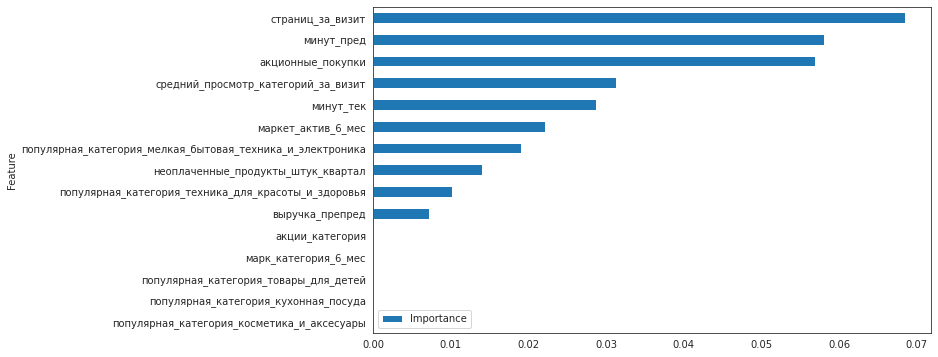

In [102]:
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 

Самими значимыми признаками являются количество просмотренных страниц за один визит, количество покупок по акции и количество минут, проведенных на сайте, а самыми незначимыми - категория товаров для детей, кухонная посуда, косметика и аксесуары и тип клиента по количеству акционных покупок

In [103]:
explainer = shap.Explainer(model.predict, X_test_new)
X_test_shap = pd.DataFrame(X_test_new, columns = features_names)
shap_values = explainer(X_test_shap)

PermutationExplainer explainer: 325it [01:11,  4.06it/s]                         


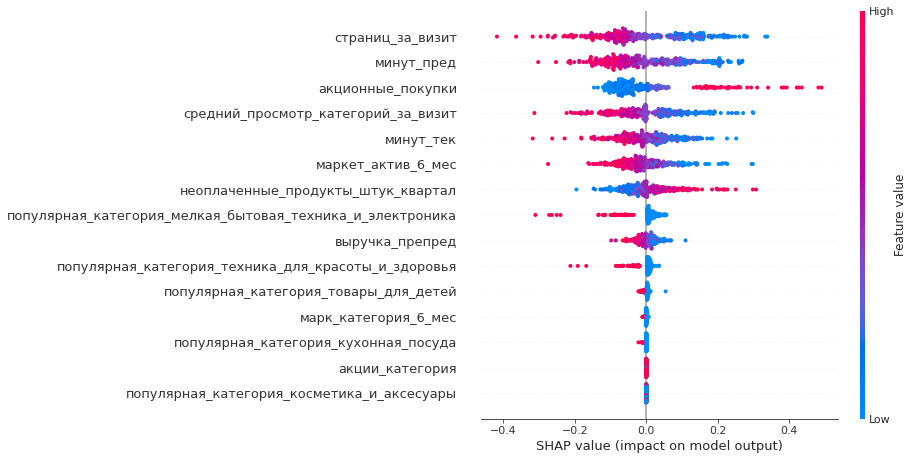

In [104]:
shap.plots.beeswarm(shap_values, max_display=16) 

Из данного графика следует:
- чем больше страниц посещает покупатель, смотрит больше категорий за один визит и чем больше минут провел на сайте в текущем и предыдущем месяце - тем выше покупательская активность
- количество акционных покупок и неоплаченные покупки в корзине негативно влияют на показатель активности
- маркетинговая активность положительно влияет на цель
- товары с высокой покупательской активностью - техника для красоты и здоровья и мелка бытовая техника и электроника

# Шаг 7. Вывод 

На данном этапе мы оценили важность признаков для лучшей модели, построенной с помощью метода опорных векторов. 
Самыми влиятельными оказались количество просмотренных страниц за один визит, количество покупок по акции и количество минут, проведенных на сайте. 

С помощью диаграммы SHAP получили следующие наблюдения:
- наиболее положительно на показатель покупательской активности влияют количество просмотренных страниц за визит и время, проведенное на сайте в предыдущем и текущем месяце
- количество покупок по акции и неоплаченных продуктов в корзине - негативно влияют на показатель
- категории с самым высоким влиянием на уровень активности - техника для здоровья и красоты, мелкая бытовая техника и лектроника
- маркетинговая активность - положительно влияет на уровень ПА

Отсюда можно выделить следующие рекомендации для бизнеса:
- умеренно увеличить уровень маркетинговой активности
- увеличить долю продуктов из категорий - техника для здоровья и красоты, мелкая бытовая техника и электроника
- для увеличения времени проводимого покупателем на сайте: добавить больше позиций товара, добавить контента (обзор на товар, отзывы от покупателей), добавить рекомендации для каждого пользователя самых популярных позиций из других категорий или похожий товаров, которые заинтересовали пользователя

## Сегментация покупателей

Выполним сегментацию покупателей
Для начала объединим данные **total_data** с данными о прибыльности 

In [105]:
data = total_data.merge(money_pr, on = 'id', how = 'left')
data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,марк_категория_6_мес,марк_категория_мес,акции_категория,минут_тек,минут_пред,выручка_препред,выручка_пред,выручка_тек,ПА,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,средняя,средняя,выше среднего,10.0,12.0,4472.0,5216.0,4971.6,1.0,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,средняя,низкая,ниже среднего,13.0,8.0,4826.0,5457.5,5058.4,1.0,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,средняя,высокая,выше среднего,13.0,11.0,4793.0,6158.0,6610.4,1.0,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,средняя,низкая,выше среднего,11.0,8.0,4594.0,5807.5,5872.5,1.0,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,средняя,средняя,ниже среднего,10.0,10.0,5124.0,4738.5,5388.5,1.0,3.95


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

Выделим только ключевые признаки
- Страниц_за_визит
- минут_тек
- минут_пред
- Акционные_покупки
- Средний_просмотр_категорий_за_визит
- Неоплаченные_продукты_штук_квартал 
- Маркет_актив_6_мес
- Популярная_категория

In [107]:
data = data[['покупательская_активность', 'страниц_за_визит', 'минут_тек', 'минут_пред', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', \
            'неоплаченные_продукты_штук_квартал', 'маркет_актив_6_мес', 'популярная_категория', 'прибыль']]

Отберем клиентов, для которых модель прогнозирует высокую и низкую покупательскую активность

In [108]:
Y_pred = pd.DataFrame(randomized_search.predict(total_data[cols]))
Y_pred

,0
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
1291,0.0
1292,0.0
1293,0.0
1294,0.0


In [109]:
data['predict'] = Y_pred
data

,покупательская_активность,страниц_за_визит,минут_тек,минут_пред,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,маркет_актив_6_мес,популярная_категория,прибыль,predict
0,Снизилась,5,10.0,12.0,0.75,4,4,4.4,Товары для детей,4.16,1.0
1,Снизилась,5,13.0,8.0,0.14,5,2,4.9,Домашний текстиль,3.13,0.0
2,Снизилась,4,13.0,11.0,0.99,5,0,3.2,Товары для детей,4.87,1.0
3,Снизилась,2,11.0,8.0,0.94,3,2,5.1,Товары для детей,4.21,1.0
4,Снизилась,4,10.0,10.0,0.26,4,1,3.3,Домашний текстиль,3.95,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1291,Прежний уровень,11,7.0,14.0,0.24,5,3,6.6,Техника для красоты и здоровья,4.44,0.0
1292,Прежний уровень,9,11.0,12.0,0.21,6,2,5.1,Домашний текстиль,6.11,0.0
1293,Прежний уровень,7,18.0,12.0,0.20,3,2,4.1,Домашний текстиль,3.29,0.0
1294,Прежний уровень,7,7.0,18.0,0.12,3,3,6.3,Техника для красоты и здоровья,4.03,0.0


Объединим в две группы пользователей сервиса на основании двух признаков - результатов моделирования и прибыли

In [110]:
kmeans = KMeans(n_clusters = 3, random_state=42)

In [111]:
kmeans.fit(data[['predict', 'прибыль']])
kmeans_pred_res = kmeans.predict(data[['predict', 'прибыль']])
kmeans_centroinds = kmeans.cluster_centers_

Text(0, 0.5, 'прибыль')

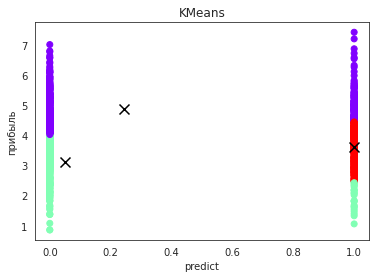

In [112]:
plt.scatter(data['predict'], data['прибыль'], c=kmeans_pred_res, cmap="rainbow")
plt.scatter(kmeans_centroinds[:, 0], kmeans_centroinds[:, 1], marker="x", color="black", s=100)
plt.title("KMeans")
plt.xlabel("predict")
plt.ylabel("прибыль")

Получили три группы покупателей:
- низкая или высокая покупательская активность, но низкая прибыль
- низкая покупательская активность и высокая прибыль
- высокая покупательская активность и высокая прибыль

Самым проблематичной группой для бизнеса является первый пункт. Проведем ее исследование

In [113]:
data['group'] = pd.DataFrame(kmeans_pred_res)
data_res = data[(data['group'] == 0)]
data_low = data[(data['group'] == 0) & (data['predict'] == 1)]
data_high = data[(data['group'] == 0) & (data['predict'] == 0)]

Проведем исследование группы покупателей, у которых покупательская активность согласно модели снизилась

In [114]:
data['страниц_за_визит'].describe()

count    1296.000000
mean        8.187500
std         3.978459
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

In [115]:
data_res['страниц_за_визит'].describe()

count    577.000000
mean       8.615251
std        3.945062
min        1.000000
25%        6.000000
50%        8.000000
75%       11.000000
max       20.000000
Name: страниц_за_визит, dtype: float64

In [116]:
data_low['страниц_за_визит'].describe(), 

(count    140.000000
 mean       4.585714
 std        2.118727
 min        1.000000
 25%        3.000000
 50%        4.000000
 75%        6.000000
 max       11.000000
 Name: страниц_за_визит, dtype: float64,)

In [117]:
data_high['страниц_за_визит'].describe(),

(count    437.000000
 mean       9.906178
 std        3.499395
 min        3.000000
 25%        7.000000
 50%       10.000000
 75%       12.000000
 max       20.000000
 Name: страниц_за_визит, dtype: float64,)

In [118]:
columns_cat = ['общая выборка', 'исследуемая группа', 'группа с низкой ПА', 'группа с высокой ПА']

In [119]:
pages = pd.DataFrame([[data['страниц_за_визит'].median(), data_res['страниц_за_визит'].median(), data_low['страниц_за_визит'].median(), data_high['страниц_за_визит'].median()]], \
                     columns = columns_cat)
pages

,общая выборка,исследуемая группа,группа с низкой ПА,группа с высокой ПА
0,8.0,8.0,4.0,10.0


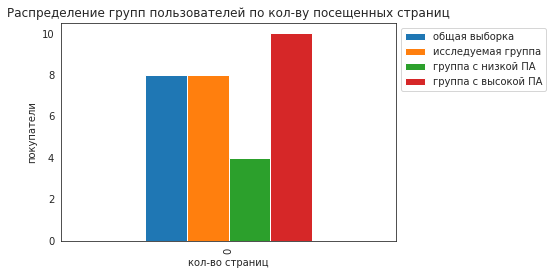

In [120]:
pages.plot(kind = 'bar')
plt.title('Распределение групп пользователей по кол-ву посещенных страниц')
plt.xlabel('кол-во страниц')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

В среднем среди пользователей всех групп средний показатель посещещенных страниц покупателем составляет 8 страниц. Для исследуемой категории "низкомаржинальных" клиентов - такой показатель остается на уровне с общей выборкой - 8 страниц

Но для категории с низкой покупательской активностью - данный показатель ниже в два раза - он составляет всего 4 страницы. 

Рассмотрим время, проведенное на сайте

In [121]:
data['минут_тек'].describe()

count    1296.000000
mean       13.210648
std         4.221794
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут_тек, dtype: float64

In [122]:
data_res['минут_тек'].describe()

count    577.000000
mean      13.597920
std        4.180543
min        4.000000
25%       10.000000
50%       13.000000
75%       17.000000
max       23.000000
Name: минут_тек, dtype: float64

In [123]:
data_low['минут_тек'].describe()

count    140.000000
mean      10.085714
std        2.612878
min        4.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       19.000000
Name: минут_тек, dtype: float64

In [124]:
data_high['минут_тек'].describe()

count    437.000000
mean      14.723112
std        3.960092
min        5.000000
25%       12.000000
50%       15.000000
75%       18.000000
max       23.000000
Name: минут_тек, dtype: float64

In [125]:
time_cur = pd.DataFrame([[data['минут_тек'].median(), data_res['минут_тек'].median(), data_low['минут_тек'].median(), data_high['минут_тек'].median()]], \
                     columns = columns_cat)

In [126]:
data['минут_пред'].describe()

count    1296.000000
mean       13.470679
std         3.937630
min         5.000000
25%        10.750000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут_пред, dtype: float64

In [127]:
data_res['минут_пред'].describe()

count    577.000000
mean      13.925477
std        3.776250
min        5.000000
25%       11.000000
50%       14.000000
75%       17.000000
max       23.000000
Name: минут_пред, dtype: float64

In [128]:
data_low['минут_пред'].describe()

count    140.000000
mean      10.257143
std        2.717837
min        5.000000
25%        8.750000
50%       10.000000
75%       12.000000
max       19.000000
Name: минут_пред, dtype: float64

In [129]:
data_high['минут_пред'].describe()

count    437.000000
mean      15.100686
std        3.283113
min        7.000000
25%       13.000000
50%       15.000000
75%       18.000000
max       23.000000
Name: минут_пред, dtype: float64

In [130]:
time_last = pd.DataFrame([[data['минут_пред'].median(), data_res['минут_пред'].median(), data_low['минут_пред'].median(), data_high['минут_пред'].median()]], \
                     columns = columns_cat)

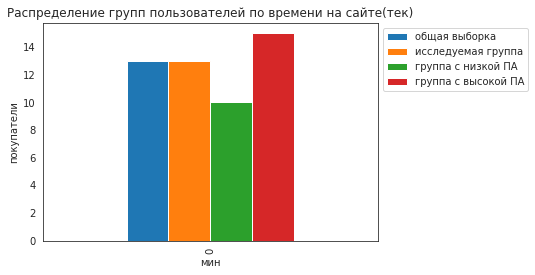

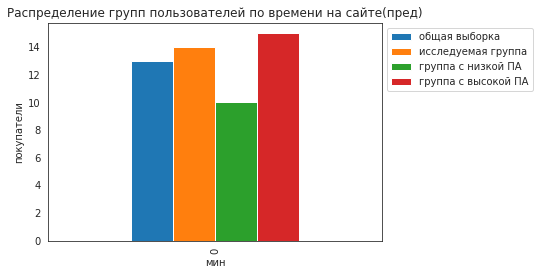

In [131]:
time_cur.plot(kind = 'bar')
plt.title('Распределение групп пользователей по времени на сайте(тек)')
plt.xlabel('мин')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

time_last.plot(kind = 'bar')
plt.title('Распределение групп пользователей по времени на сайте(пред)')
plt.xlabel('мин')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Для группы с низкой покупательской способностью медианное значение проведенного времени на сайте в текущем периоде равно с общей выборкой и а в предыдущем выше (эта группа людей много проводит времени на сайте с целью купить по самой выгодной цене).

Рассмотрим количество просматриваемых категорий

In [132]:
data['средний_просмотр_категорий_за_визит'].describe()

count    1296.000000
mean        3.267747
std         1.355125
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

In [133]:
data_res['средний_просмотр_категорий_за_визит'].describe()

count    577.000000
mean       3.311958
std        1.326707
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

In [134]:
data_low['средний_просмотр_категорий_за_визит'].describe()

count    140.000000
mean       2.350000
std        1.092321
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

In [135]:
data_high['средний_просмотр_категорий_за_визит'].describe()

count    437.000000
mean       3.620137
std        1.246042
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

In [136]:
cat = pd.DataFrame([[data['средний_просмотр_категорий_за_визит'].median(), data_res['средний_просмотр_категорий_за_визит'].median(), data_low['средний_просмотр_категорий_за_визит'].median(), data_high['средний_просмотр_категорий_за_визит'].median()]], \
                     columns = columns_cat)

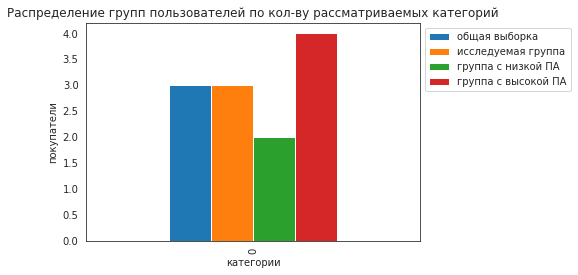

In [137]:
cat.plot(kind = 'bar')
plt.title('Распределение групп пользователей по кол-ву рассматриваемых категорий')
plt.xlabel('категории')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Чем больше просматриваемых категорий, тем выше покупательская активность

In [138]:
data['акционные_покупки'].describe()

count    1296.000000
mean        0.320069
std         0.249159
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

In [139]:
data_res['акционные_покупки'].describe()

count    577.000000
mean       0.277123
std        0.204677
min        0.110000
25%        0.170000
50%        0.230000
75%        0.280000
max        0.990000
Name: акционные_покупки, dtype: float64

In [140]:
data_low['акционные_покупки'].describe()

count    140.000000
mean       0.451643
std        0.293119
min        0.120000
25%        0.247500
50%        0.320000
75%        0.522500
max        0.990000
Name: акционные_покупки, dtype: float64

In [141]:
data_high['акционные_покупки'].describe()

count    437.000000
mean       0.221213
std        0.122638
min        0.110000
25%        0.160000
50%        0.210000
75%        0.250000
max        0.990000
Name: акционные_покупки, dtype: float64

In [142]:
sell = pd.DataFrame([[data['акционные_покупки'].median(), data_res['акционные_покупки'].median(), data_low['акционные_покупки'].median(), data_high['акционные_покупки'].median()]], \
                     columns = columns_cat)

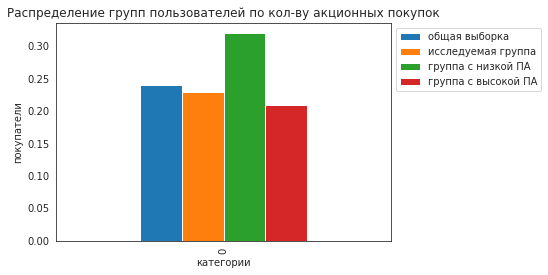

In [143]:
sell.plot(kind = 'bar')
plt.title('Распределение групп пользователей по кол-ву акционных покупок')
plt.xlabel('категории')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Покупки по акции уменьшают прибыль, но у группы с низкой покупательской активностью - этот показатель выше.

Рассмотрим показатель маркетинговой активности

In [144]:
data['маркет_актив_6_мес'].describe()

count    1296.000000
mean        4.256404
std         1.013525
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

In [145]:
data_res['маркет_актив_6_мес'].describe()

count    577.000000
mean       4.342981
std        0.951182
min        0.900000
25%        3.800000
50%        4.300000
75%        4.900000
max        6.600000
Name: маркет_актив_6_мес, dtype: float64

In [146]:
data_low['маркет_актив_6_мес'].describe()

count    140.000000
mean       3.612857
std        0.941745
min        0.900000
25%        3.100000
50%        3.800000
75%        4.100000
max        5.600000
Name: маркет_актив_6_мес, dtype: float64

In [147]:
data_high['маркет_актив_6_мес'].describe()

count    437.000000
mean       4.576888
std        0.828557
min        2.600000
25%        4.000000
50%        4.400000
75%        5.200000
max        6.600000
Name: маркет_актив_6_мес, dtype: float64

In [148]:
market = pd.DataFrame([[data['маркет_актив_6_мес'].median(), data_res['маркет_актив_6_мес'].median(), data_low['маркет_актив_6_мес'].median(), data_high['маркет_актив_6_мес'].median()]], \
                     columns = columns_cat)

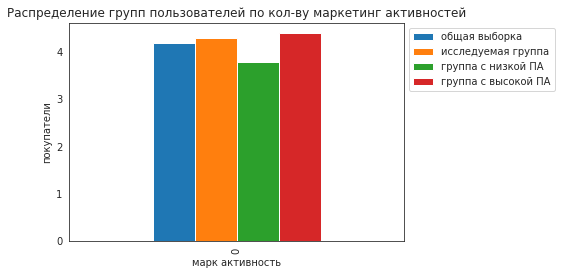

In [149]:
market.plot(kind = 'bar')
plt.title('Распределение групп пользователей по кол-ву маркетинг активностей')
plt.xlabel('марк активность')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Маркетинговая активность положительно влияет на покупательскую, но есть интересное наблюдение - у исследуемой группы данный показатель немного выше, чем у общей выборки.

Для увеличения объемов продаж следует повысить интерес пользователя к предоставляемым товарам:
- расширить разнообразие товаров
- добавить обзор на товар, отзывы
- добавить рекомендательную систему в разрезе этой же категории (похожие товары) и бестселлеры из других категорий

In [150]:
data['неоплаченные_продукты_штук_квартал'].describe()

count    1296.000000
mean        2.841821
std         1.974074
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

In [151]:
data_res['неоплаченные_продукты_штук_квартал'].describe()

count    577.000000
mean       2.641248
std        1.809858
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

In [152]:
data_low['неоплаченные_продукты_штук_квартал'].describe()

count    140.00000
mean       3.95000
std        2.10626
min        0.00000
25%        2.00000
50%        4.00000
75%        5.00000
max       10.00000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

In [153]:
data_high['неоплаченные_продукты_штук_квартал'].describe()

count    437.000000
mean       2.221968
std        1.478802
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

In [154]:
not_pay = pd.DataFrame([[data['неоплаченные_продукты_штук_квартал'].median(), data_res['неоплаченные_продукты_штук_квартал'].median(), data_low['неоплаченные_продукты_штук_квартал'].median(), data_high['неоплаченные_продукты_штук_квартал'].median()]], \
                     columns = columns_cat)

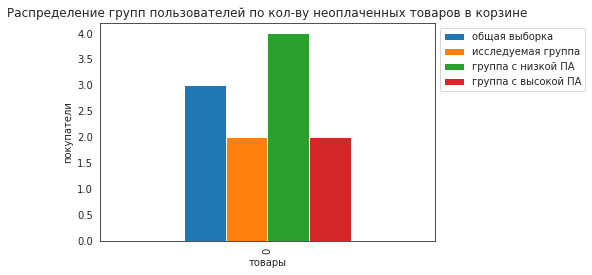

In [155]:
not_pay.plot(kind = 'bar')
plt.title('Распределение групп пользователей по кол-ву неоплаченных товаров в корзине')
plt.xlabel('товары')
plt.ylabel('покупатели')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

У группы с низкой покупательской активностью высокий показатель неоплаченных товаров в корзине - это "неактивные" пользователи. Как раз таких пользователей можно завлечь с помощью маркетинговой активности и специальных предложений

Рассмотрим распределение по категориям

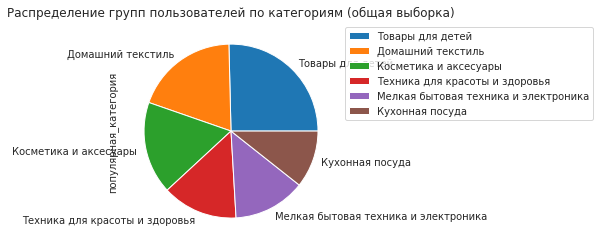

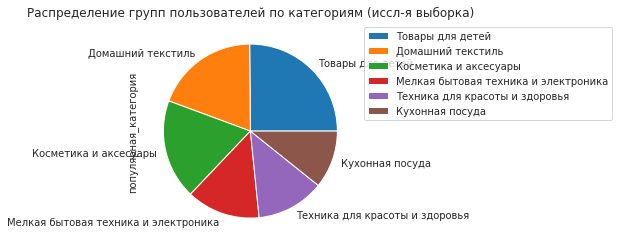

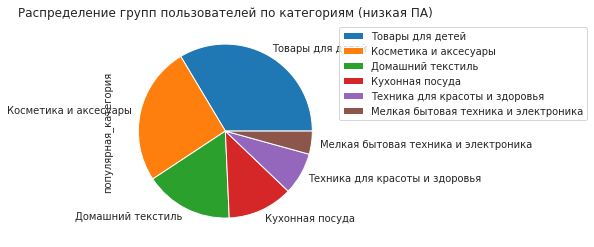

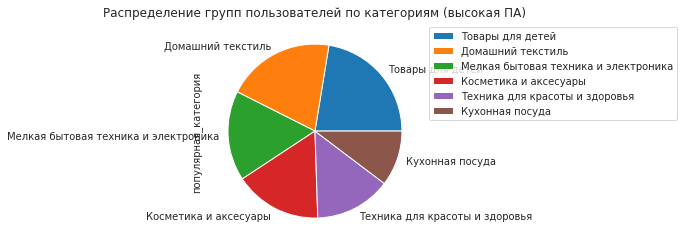

In [156]:
data['популярная_категория'].value_counts().plot(kind = 'pie')
plt.title('Распределение групп пользователей по категориям (общая выборка)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

data_res['популярная_категория'].value_counts().plot(kind = 'pie')
plt.title('Распределение групп пользователей по категориям (иссл-я выборка)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

data_low['популярная_категория'].value_counts().plot(kind = 'pie')
plt.title('Распределение групп пользователей по категориям (низкая ПА)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

data_high['популярная_категория'].value_counts().plot(kind = 'pie')
plt.title('Распределение групп пользователей по категориям (высокая ПА)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Наиболее привлекательной категорией для пользователей является мелка бытовая техника и электроника, а менее привлекательной - товары для детей и косметика и аксессуары

# Шаг 8. Вывод 


Для увеличения покупательской активности и следовательно объемов продаж необходимо улучшить показатель количества просматриваемых страниц, категорий, увеличить проведенное время на сайте: расширить каталог товаров, добавить контента (обзор на товар, отзывы от покупателей), сделать рекомендательную систему для каждого пользователя самых популярных позиций из других категорий или похожих товаров, которые заинтересовали потенциального покупателя

Покупки по акции негативно влияют на покупательскую активность - если у компании стоит цель о расширении количества активных клиентов, то лучше не увлекаться черезчур частыми предложениями о скидке

С помощью более частой маркетинговой активности компания может повысить уровень покупательской, но она может немного снизить значение прибыли. Так как часто положительной маркетинговой активностью является предложение о скидке и акциях - компании следует очень аккуратно пользоваться этим инструментом. Так как мы выяснили ранее - акционные покупки могут привлекать "одноразовых" клиентов

Из всех категорий товаров лучше всего сосредоточиться на технике для красоты и здоровья и мелкой бытовой технике. Такие товары как Товары для детей и Косметика и аксессуары привлекают пользователей меньше

## Общий вывод

В проводимом исследовании была построена модель для предсказывания уровня покупательской активности компании "Один клик" и на основе ее и данных о прибыли были сформированы рекомендации для развития бизнеса и изменения стратегии продаж. 

В исходных данных содержалась инфомрмация 
- о выручке за последние 3 месяца, 
- категориях клиеннта (премиум, стандарт), 
- характеристиках действий пользователя (количество просматриваемых страниц, категорий, неоплаченных товаров в корзине, времени проведенном на сайте в текущей и прошлом периоде)
- оценка маркетинговой активности на пользователя в разрезе текущего периода и полгода
- ошибки на сайте
- информация о категориях товара

Была выполнена предобработка данных и исследовательский анализ данных, на основании которых были получены следующие наблюдения:
- Лишь у 38% покупателей снизилась покупательская способность
- Покупатели с сервисом Премиум охотнее соглашаются на получение дополнительных предложений о товаре (86.9%). У покупателей с сервисом стандарт этот показатель заметно ниже - 68.7%
- У покупателей с более низким показателем покупательской активности ниже среднее значение маркетинговой активности за последние полгода. Различная реклама, рассылки, предложения, звонки положительно влияют на уровень продаж и как следствие - на активность покупателей. При этом на покупательскую активность не отразилось значение маркетинговых мероприятий за последний месяц, что может говорить о возможной неэффективности маркетинговых инициатив.
- В среднем покупатели зарегистрированы на сервисе около 600 дней. Основная часть пользователей зарегистрирована от 400 до 800 дней. Среди покупателей с подпиской Премиум - много "старожилов", при этом среди новых покупателей доля таких заметно ниже. 
- Топ-3 самых популярный категорий покупателей - товары для детей, домашний текстиль и косметика и аксесуары
- У преобладающего числа пользователей есть неоплаченные позиции в корзине - в среднем это значение составляет 3 товара.
- Более 99% покупателей сталкивались с ошибкой сервиса, что говорит о наличии в системе массового сбоя
- В среднем выручка по покупателям составляет 5000 руб при довольно невысокой прибыли - 4 рубля. За последние три месяца средняя выручка за месяц увеличивается

Для выбора факторов в модель был проведен корреляционный анализ. Были выделены следующие признаки:
- маркетинговая активность за последние 6 месяцев
- количество акционных покупок
- популярная категория
- количество просмотров категорий за визит
- количество неоплаченных продуктов
- количество просмотренных страниц за визит
- количество минут проведенных на сайте в предыдущий и текущий период
- выручка в препредыдущем периоде
- а также категории клиентов, которые мы выделили ранее по количеству акционных покупок и маркетинговой активности

На основании полученных факторов общая выборка была разделена на тренировочную и тестовую. Подготовлен общий PipeLine для всех моделей с подбором гиперпараметров: 

- DecisionTreeClassifier(), 
- LogisticRegression()

C помощью метрики ROC-AUC выбрана лучшая модель - логистическая регрессия. Он составил 0,9 для обучающей выборки и 0,92 для тестовой.

Был проведен общий анализ важности признаков SHAP и были выделены наиболее значительные признаки, влияющие на уровень покупательской активности:
- наиболее положительно на показатель покупательской активности влияют количество просмотренных страниц за визит и время, проведенное на сайте в предыдущем и текущем месяце
- количество покупок по акции и неоплаченных продуктов в корзине - негативно влияют на показатель
- категории с самым высоким влиянием на уровень активности - техника для здоровья и красоты, мелкая бытовая техника и лектроника и товары для детей, при этом Кухонная посуда - снижает целевой показатель
- маркетинговая активность - положительно влияет на уровень ПА

Проведена сегментация покупателей на основе полученных результатов и данных о прибыли. Была выделена самая рискованная группа с низкой прибылью и выделены две подгруппы - с высокой и низкой покупательской активностью

Общей прибылью любого бизнеса можно управлять с помощью факторов увеличение объема и прибыли за единицу.
В зависимости от задач - увеличиении прибыли на единицу товара или увеличении объемов продаж и расширении количества покупателей были выстроены следующие рекомендации:
- повысить интерес покупателя к сайту: увеличить среднее время нахождения на сайте, количество просматриваемых страниц, количество товара, добавить рекомендальные системы товаров и категорий
- быть более аккуратным с маркетинговыми стратегиями и акциями - данные мероприятия привлекают клиентов, но могут отрицательно отразиться на прибыли
- из всех категорий товаров лучше сосредоточиться на технике для красоты и здоровья и мелкой бытовой технике и электронике - у них высокая покупательская активность и прибыль